In [2]:

import PyROA
import os
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import os
import glob
import scienceplots
import sys
sys.path.insert(0, os.path.abspath('..'))
import rm_utils
sys.path.insert(0, os.path.abspath('../..'))
import utils
np.random.seed(2) 
torch.manual_seed(2)

In [111]:
files = glob.glob('pyroa_fits/NGC5548_[0-9]*3_*')
files

['pyroa_fits/NGC5548_3_gri_seg3_10_det',
 'pyroa_fits/NGC5548_1_epoch3_det',
 'pyroa_fits/NGC5548_2_gri_seg3_10_det',
 'pyroa_fits/NGC5548_0_epoch3_det',
 'pyroa_fits/NGC5548_0_gri_seg3_10_det',
 'pyroa_fits/NGC5548_2_epoch3_det',
 'pyroa_fits/NGC5548_1_gri_seg3_10_det']

NGC5548_3_GRI_SEG3_10_DET t1=2.4736440841104255,t2=0.5145606079913896,delt=20.030285479997808
0.0
1.6073169718361513


/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_28705/1391870631.py:36: RuntimeWarning: invalid value encountered in double_scalars
  mu = np.log(mean**2/np.sqrt(mean**2 + sig**2))
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_28705/1391870631.py:37: RuntimeWarning: invalid value encountered in double_scalars
  stddev2 = np.log( 1.0+ (sig**2)/(mean**2))


0.14839106629432708


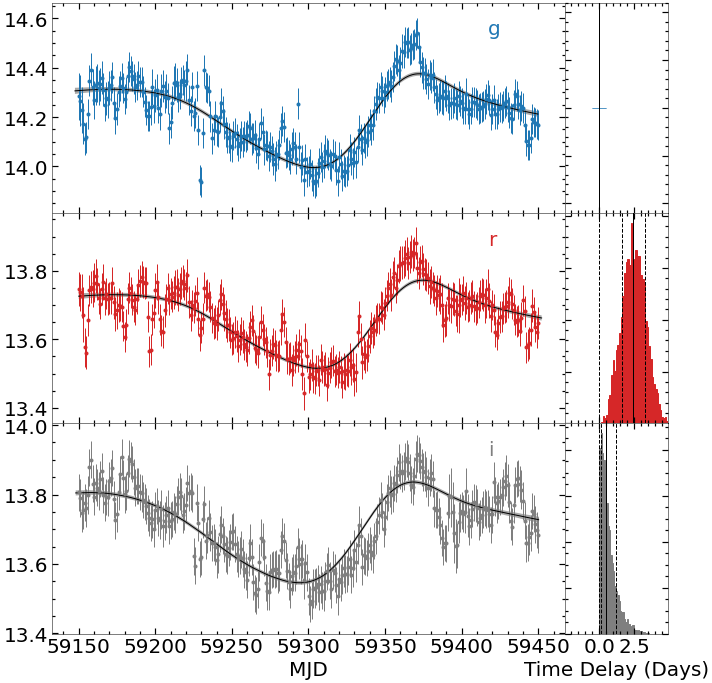

NGC5548_1_EPOCH3_DET t1=2.2085189583126077,t2=1.6335292604236114,delt=5.767344364381566
0.0
1.565603150582863
1.0014751385854168


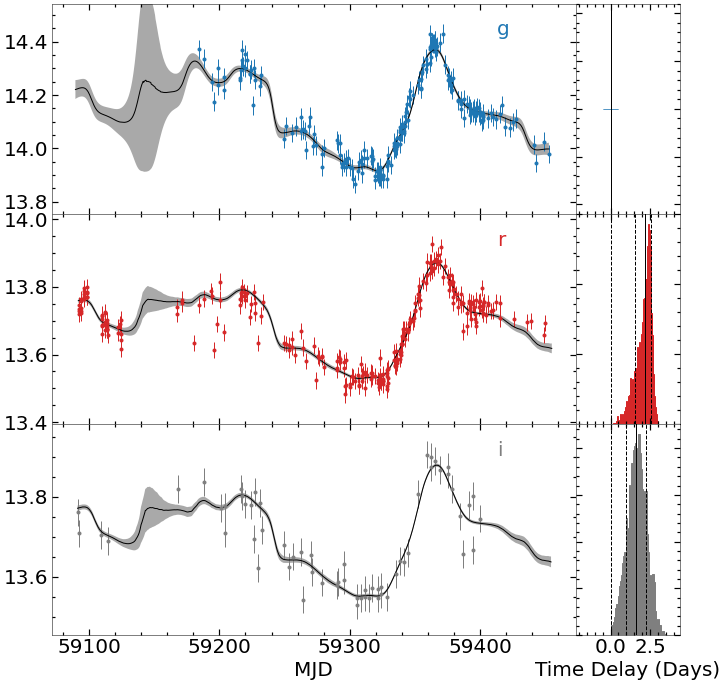

NGC5548_2_GRI_SEG3_10_DET t1=1.5069516410245463,t2=1.667049781040253,delt=10.040173274360065
0.0
1.0057287968947626
0.9285765616322372


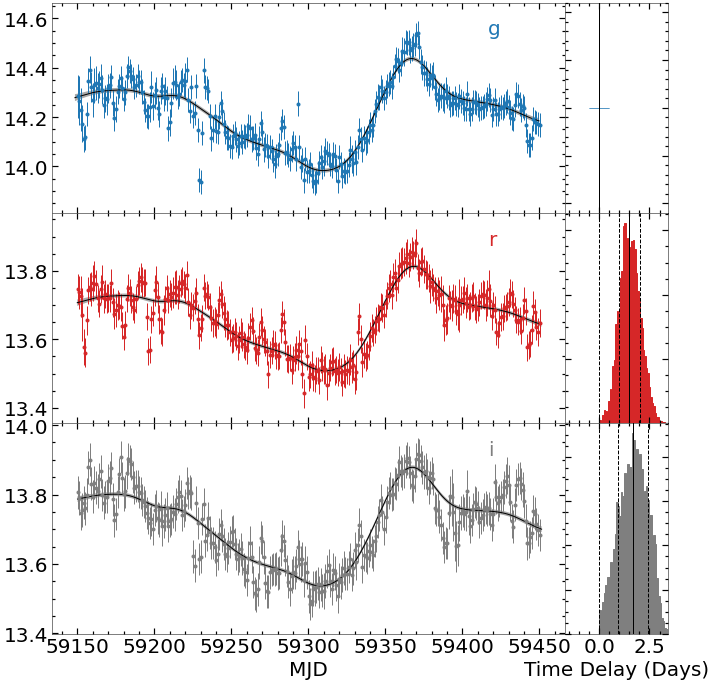

NGC5548_0_EPOCH3_DET t1=2.1449160599505426,t2=1.6568328618663095,delt=5.778185105480841
0.0
1.2114529239476
1.0220076564709863


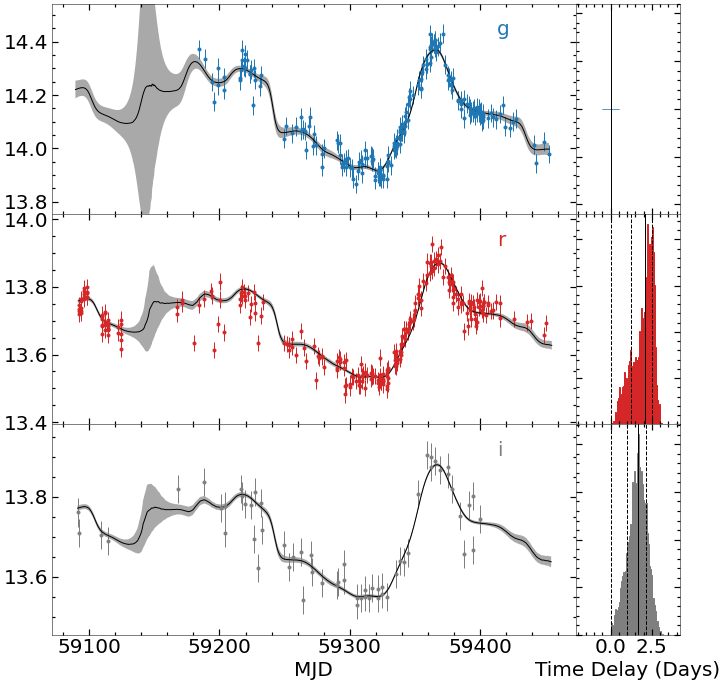

NGC5548_0_GRI_SEG3_10_DET t1=1.2364711001461397,t2=1.4502064162133987,delt=4.788563622801636
0.0
0.8685876927610905
1.0384611775553563


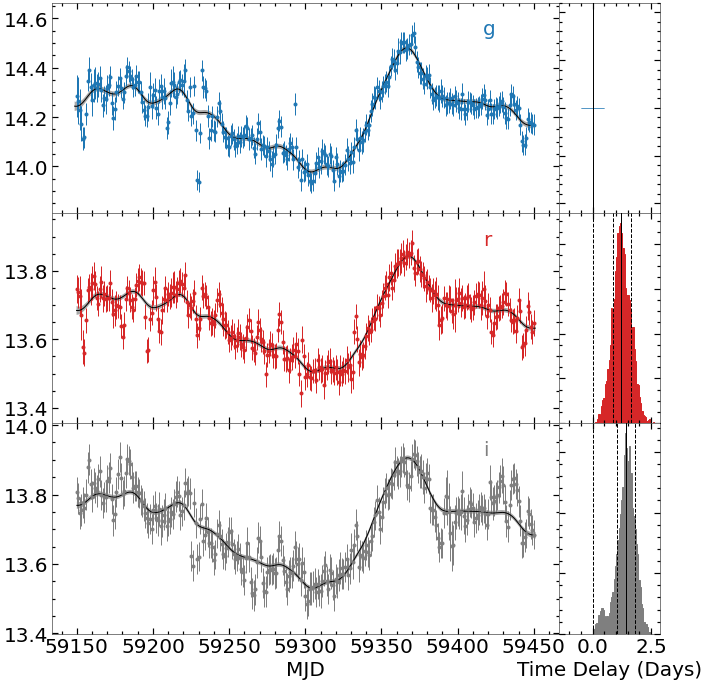

NGC5548_2_EPOCH3_DET t1=0.2952383161776089,t2=1.2638714478983304,delt=10.017893730046477
0.0
0.06856634308850137
0.5744640196907016


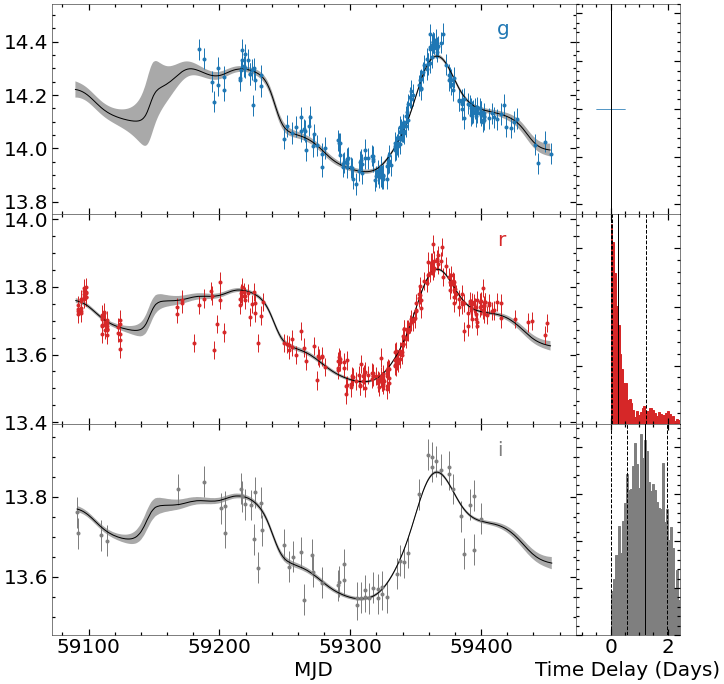

NGC5548_1_GRI_SEG3_10_DET t1=1.3165556502514242,t2=1.6064784213562862,delt=5.19816925039667
0.0
0.9680859900901795
1.255895678846895


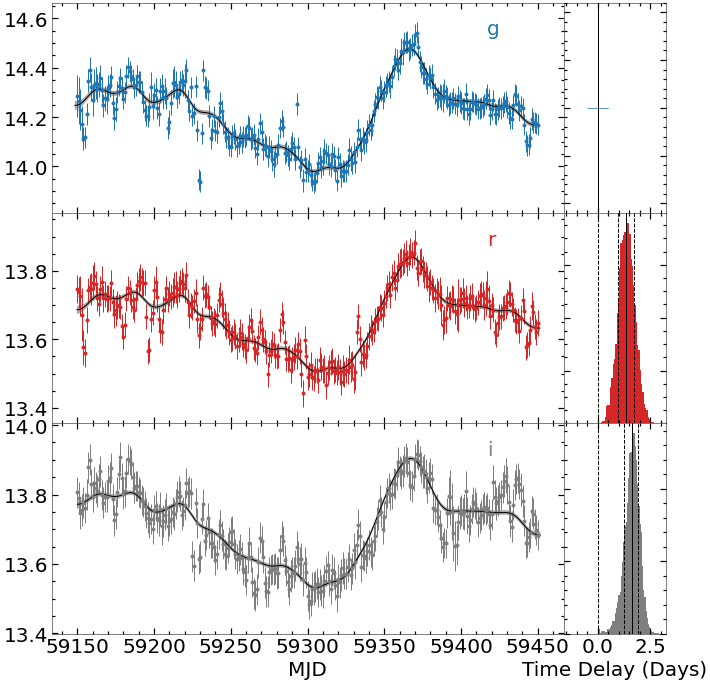

In [119]:
filters = ['g','r','i']
obj = 'NGC5548'
for file in files:
    fit = utils.load_obj(file)
    fit.datadir = os.path.join('../..',fit.datadir)
    t1 = fit.params[5]
    t2 = fit.params[10]
    delt = fit.params[-1]
    print(file.split('/')[-1].upper(),f'{t1=},{t2=},{delt=}')
    fit.samples_flat = fit.samples_flat[:-5000]
    sp = os.path.join('pyroa_fits',f'{obj}_fit_plots',file.split('/')[-1])
    ploot(fit,figsize=[10,10],save_file=sp)
    

    
    
    

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import interpolate
import emcee
from tqdm import tqdm
from multiprocessing import Pool
from itertools import chain
from tabulate import tabulate
import corner
from astropy.modeling import models
import os
import pickle
import numba
from numba import jit
from numba import prange
from numba.typed import List
from numba import generated_jit, types
from scipy import special
import scipy.special
import matplotlib
from astropy.modeling import models
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import quad
import csv
from pandas import DataFrame

def Gaussian(mean, sig, t, conv):
    if (conv==True):
        mean = 0.0
    return np.exp(-0.5*((t-mean)/sig)**2)

def LogGaussian(mean, sig, t, min_delay, conv):
    mean = mean - min_delay # set zero point to min delay    
    mu = np.log(mean**2/np.sqrt(mean**2 + sig**2))
    stddev2 = np.log( 1.0+ (sig**2)/(mean**2))

    if (conv == True):
        t = t + mean # Shift time grid to centre on mean
        psi = np.zeros(len(t))
        ts = t[t>0]
        psi[t>0] = (1.0/(ts*np.sqrt(stddev2 *2.0*np.pi)))*np.exp(- 0.5 * (np.log(ts) - mu) ** 2 / stddev2)
    else:
        try:
            t_shift = t - min_delay   
            psi = np.zeros(len(t_shift))
            ts = t_shift[t_shift>0]
            psi[t_shift>0] = (1.0/(ts*np.sqrt(stddev2 *2.0*np.pi)))*np.exp(- 0.5 * (np.log(ts) - mu) ** 2 / stddev2)
        except:
            psi = np.zeros(len(mu))        
            for i in range(len(min_delay)):
                t_shift = t - min_delay[i]
                if (t_shift > 0):
                    psi[i] = (1.0/(t_shift*np.sqrt(stddev2[i] *2.0*np.pi)))*np.exp(- 0.5 * (np.log(t_shift) - mu[i]) ** 2 / stddev2[i])
                else:
                    psi[i]=0.0
    return psi

def ploot(Fit,figsize=[15,20],save_file=''):

    plt.style.use(['science','no-latex'])        
    plt.rcParams.update({
            "font.family": "Sans", 
            "font.serif": ["DejaVu"],
            "figure.figsize":figsize,
            "font.size": 20,
            "xtick.major.size" : 6,
            "xtick.major.width": 1.2,
            "xtick.minor.size" : 3,
            "xtick.minor.width" : 1.2,
            "ytick.major.size" : 6,
            "ytick.major.width": 1.2,
            "ytick.minor.size" : 3,
            "ytick.minor.width" : 1.2}) 



    datadir =Fit.datadir
    objName = Fit.objName
#     filters=Fit.filters
    data=[]
    for i in range(len(filters)):
        file = datadir + str(objName) +"_"+ str(filters[i]) + ".dat"
        data.append(np.loadtxt(file))


    cmap = matplotlib.cm.get_cmap('tab10')
    band_colors=[]
    n = np.arange(0.05, 1.0 + 0.5/len(filters), 1.0/len(filters))
    for i in range(len(filters)):
        band_colors.append(cmap(n[i]))

    samples_flat = Fit.samples_flat
    t = Fit.t
    X=Fit.X
    errs= Fit.X_errs
    
    
    transpose_samples = np.transpose(samples_flat)      
    

        

    Nchunk = 2
    if (Fit.AccDisc == False):
        Nchunk+=1
       
        
    
    if (Fit.add_var == True):
        Nchunk +=1
    if (Fit.delay_dist == True and Fit.AccDisc == False):
        Nchunk+=1
        
        if (Fit.delay_ref_pos == 0):
            transpose_samples=np.insert(transpose_samples, [2], np.array([0.0]*len(transpose_samples[1])), axis=0)              #Insert zero for reference delay dist
        else:
            transpose_samples=np.insert(transpose_samples, [3], np.array([0.0]*len(transpose_samples[1])), axis=0)              #Insert zero for reference delay dist
        
        
        param_delete=2
    else:
        param_delete=1
        

                 
    Npar =  Nchunk*len(data) + 1
    if (Fit.AccDisc == True):
        Npar =  Nchunk*len(data) + 3
        
    pos = Fit.delay_ref_pos*Nchunk + 2
    if (Fit.AccDisc == False):
        transpose_samples= np.insert(transpose_samples, pos, np.array([0.0]*len(transpose_samples[1])), axis=0)    #Insert zero for reference delay 

    

    chunk_size = Nchunk#int((Npar - 1)/len(data))

           
    samples_chunks = [transpose_samples[i:i + chunk_size] for i in range(0, len(transpose_samples), chunk_size)]
    
            
    if (Fit.AccDisc == True):
        T1 = np.percentile(samples_chunks[-1][0], [16, 50, 84])[1]
        b = np.percentile(samples_chunks[-1][1], [16, 50, 84])[1]        
                #Integral and interpolate
        Is=[]
        bs = np.linspace(0.34, 10.0, 5000)
        for i in range(len(bs)):
            Is.append(quad(integrand, 0, np.inf, args=(bs[i]))[0])
        integral= interpolate.interp1d(bs, Is, kind="linear", fill_value="extrapolate")
        Is=[]
        bs = np.linspace(0.34, 10.0, 5000)
        for i in range(len(bs)):
            Is.append(quad(integrand2, 0, np.inf, args=(bs[i]))[0])
        integral2= interpolate.interp1d(bs, Is, kind="linear", fill_value="extrapolate")
        
        
    fig = plt.figure(100)
    gs = fig.add_gridspec(len(filters), 2, hspace=0, wspace=0, width_ratios=[5, 1])
    axs= gs.subplots(sharex='col') 
    tss=[]    
    for j in range(len(filters)):

        #Read in parameter values
        A = np.percentile(samples_chunks[j][0], [16, 50, 84])[1]
        B = np.percentile(samples_chunks[j][1], [16, 50, 84])[1]
        if (Fit.AccDisc == False):
            tau = np.percentile(samples_chunks[j][2], [16, 50, 84])[1]
            tau_samples=samples_chunks[j][2]
            if (Fit.delay_dist == True):
                tau_rms = np.percentile(samples_chunks[j][3], [16, 50, 84])[1]
        else:
            l_0 = Fit.wavelengths[0]
            l = Fit.wavelengths[j] - l_0        
            l_delay_ref = Fit.wavelengths[Fit.delay_ref_pos] - l_0
            tau_0 = (l_0*1e-10*1.3806e-23*T1/(6.63e-34*3e8))**(1.0/b)
            tau = tau_0*((l/l_0)**(1.0/b))*8.0*(np.pi**4)/(15.0*integral(b)) - tau_0*((l_delay_ref/l_0)**(1.0/b))*8.0*(np.pi**4)/(15.0*integral(b)) #Measure mean from delay reference
            tau_rms = np.sqrt((tau_0**2)*((l/l_0)**(2.0/b))*integral2(b)/integral(b))
            
            if (j==0):
                min_delay = tau
            
            tau_samples = (l_0*1e-10*1.3806e-23*samples_chunks[-1][0]/(6.63e-34*3e8))**(1.0/samples_chunks[-1][1])*((l/l_0)**(1.0/samples_chunks[-1][1]))*8.0*(np.pi**4)/(15.0*integral(samples_chunks[-1][1])) - (l_0*1e-10*1.3806e-23*samples_chunks[-1][0]/(6.63e-34*3e8))**(1.0/samples_chunks[-1][1])*((l_delay_ref/l_0)**(1.0/samples_chunks[-1][1]))*8.0*(np.pi**4)/(15.0*integral(samples_chunks[-1][1]))
        tss.append(tau)

        
        mjd = data[j][:,0]
        flux = data[j][:,1]
        err = data[j][:,2] 
        
        
        #Add extra variance
        if (Fit.add_var == True):
            sig = np.percentile(samples_chunks[j][-1], [16, 50, 84])[1]  
            err = np.sqrt(err**2 + sig**2)
        
        ts, model, errs = Fit.models[j]
        

        axs[j][0].errorbar(mjd, flux , yerr=err, ls='none', marker=".", color=band_colors[j])
        axs[j][0].plot(ts, model, color="black")
        axs[j][0].fill_between(ts , model+errs,  model-errs, facecolor="darkgrey", edgecolor='none', rasterized=True, antialiased=True)
        
        if (Fit.include_slow_comp == True):
            slow_comp = Fit.slow_comps[j]
            axs[j][0].plot(t, slow_comp(t)+B, linestyle="dashed", color="black")          
        
        length=abs(max(flux)-min(flux))
        axs[j][0].set_ylim(min(flux)-0.2*length, max(flux)+0.2*length)
        axs[j][0].set_xlabel("MJD")
        
        axs[j][0].annotate(filters[j], xy=(0.85, 0.85), xycoords='axes fraction', color=band_colors[j], fontsize=20) 
        
        
      #  if (i>0 and i!=Fit.delay_ref_pos):
         #   smpls = peaktomean(samples_chunks[j][2], samples_chunks[0][2], samples_chunks[j][3])
       # else:
        smpls = tau_samples
        if (Fit.psi_types[j] == "TruncGaussian" and Fit.AccDisc == False):
            smpls = peaktomean(samples_chunks[j][2], samples_chunks[0][2], samples_chunks[j][3])
        
        frq, edges = np.histogram(smpls, bins=50)        
        if (Fit.delay_dist==True or Fit.AccDisc == True):
            
            
            # Transfer Function
            if (Fit.psi_types[j] == "Gaussian"and Fit.AccDisc == False):
                psi = Gaussian(tau, tau_rms, np.linspace(-4.0*tau_rms, 4.0*tau_rms, 200), conv = False)
            elif(Fit.psi_types[j] ==  "Uniform"and Fit.AccDisc == False):
                psi = Uniform(tau, tau_rms, np.linspace(-4.0*tau_rms, 4.0*tau_rms, 200), conv = False) 
            elif(Fit.psi_types[j] ==  "TruncGaussian"and Fit.AccDisc == False):
                psi = TruncGaussian(tau, tau_rms, np.linspace(-4.0*tau_rms, 4.0*tau_rms, 200), np.percentile(samples_chunks[0][2], [16, 50, 84])[1], conv = True) 
            elif(Fit.psi_types[j] == "LogGaussian"and Fit.AccDisc == False):
                psi = LogGaussian(tau, tau_rms, np.linspace(tau-4.0*tau_rms,tau+ 4.0*tau_rms, 200), np.percentile(samples_chunks[0][2], [16, 50, 84])[1], conv=False)
            elif(Fit.psi_types[j] == "InverseGaussian"and Fit.AccDisc == False):
                psi = InverseGaussian(tau, tau_rms, np.linspace(tau-4.0*tau_rms,tau+ 4.0*tau_rms, 200), np.percentile(samples_chunks[0][2], [16, 50, 84])[1], conv=False)    
            elif (Fit.AccDisc == True):
                if (j>0):
                    psi = AccDisc(Fit.wavelengths[0], Fit.wavelengths[j] - Fit.wavelengths[0], T1, b, integral, np.linspace(tau-4.0*tau_rms,tau+ 4.0*tau_rms, 200), min_delay,conv = False)
                else:
                    psi = np.ones(200)
                
                        
                
            norm = np.max(psi)
            norm = norm/max(frq)
            if (Fit.delay_ref_pos>0 and j==0 and Fit.AccDisc == False):
                norm = 1.0
            
        else:
            norm=1.0/max(frq)

        
                
        

        axs[j][1].bar(edges[:-1], frq*norm, width=np.diff(edges), edgecolor=band_colors[j], align="edge", color=band_colors[j])  
        #axs[j][1].hist(tau_samples, color=band_colors[j], bins=50, density=True)
        axs[j][1].axvline(x = np.percentile(smpls, [16, 50, 84])[1], color="black")
        axs[j][1].axvline(x = np.percentile(smpls, [16, 50, 84])[0] , color="black", ls="--")
        print(np.percentile(smpls, [16, 50, 84])[0])
        axs[j][1].axvline(x = np.percentile(smpls, [16, 50, 84])[2], color="black",ls="--")
        axs[j][1].axvline(x = 0, color="black",ls="--")    
        axs[j][1].set_xlabel("Time Delay (Days)")

        if (Fit.delay_dist==True or Fit.AccDisc == True):
            if (j>0 and Fit.AccDisc == False):

                tau_rms = np.percentile(samples_chunks[j][3], [16, 50, 84])
            
                length=10.0*tau_rms[1]
                taus=np.arange(tau - 5.0*tau_rms[1], tau + 5.0*tau_rms[1], length/500)
                if(Fit.psi_types[j] == "LogGaussian" or Fit.psi_types[j] == "InverseGaussian"):
                    taus=np.linspace(tss[0]-tau_rms[1], np.percentile(samples_chunks[-2][2], [16, 50, 84])[1] + 5.0*tau_rms[1]  , 600)
            
                #Limits for errors
                up=[]
                low=[]
                Gs = []
                for k in range(len(taus)):
                    rms_samples = samples_chunks[j][3]
                    mean_samples = samples_chunks[j][2]

                    # Transfer Function
                    if (Fit.psi_types[j] == "Gaussian"and Fit.AccDisc == False):
                        psi = Gaussian(mean_samples, rms_samples, taus[k], conv = False)
                    elif(Fit.psi_types[j] ==  "Uniform"and Fit.AccDisc == False):
                        psi = Uniform(mean_samples, rms_samples, taus[k], conv = False)
                    elif(Fit.psi_types[j] ==  "TruncGaussian"and Fit.AccDisc == False):  
                        psi = TruncGaussian(mean_samples, rms_samples, taus[k], samples_chunks[0][2], conv = False)  
                    elif(Fit.psi_types[j] == "LogGaussian"and Fit.AccDisc == False):
                        psi = LogGaussian(mean_samples, rms_samples, taus[k], samples_chunks[0][2], conv = False)   
                    elif(Fit.psi_types[j] == "InverseGauss"and Fit.AccDisc == False):
                        psi = InverseGaussian(mean_samples, rms_samples, taus[k], samples_chunks[0][2], conv = False)       
                    elif (Fit.AccDisc == True):
                        psi = AccDisc(l_0, l, samples_chunks[-1][0], samples_chunks[-1][1], integral, taus[k], min_delay, conv = False)
                     
                    percent =  np.percentile(psi, [16, 50, 84])
                    up.append(percent[0])
                    Gs.append(percent[1])
                    low.append(percent[2])

#                 axs[j][1].plot( taus, Gs, color="black", lw=1.5)                    
                
#                 axs[j][1].fill_between(taus, up, low, color="black", alpha=0.5, edgecolor='none', rasterized=True, antialiased=True)
                


    length = max(tss)-min(tss)        
    axs[-1][1].set_xlim(min(tss)-1.0*length, max(tss)+1.0*length)
            
            
            
            
            
            
            
        
    for ax in axs.flat:
        ax.label_outer()    
    
    plt.tight_layout() 
    if save_file: plt.savefig(save_file)
    plt.show() 
    
